<a href="https://colab.research.google.com/github/ronykroy/DNN-NLP-and-other-stuff/blob/master/Bert_pytorch_NewsGroups_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Source # https://mccormickml.com/2019/07/22/BERT-fine-tuning/
# https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO

V2 an attempt to address the max seq length that fits bert model...  
By truncation

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [3]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 6.5MB/s 
     |████████████████████████████████| 92kB 12.9MB/s 
     |████████████████████████████████| 645kB 43.9MB/s 


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io, os , re
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0) 
# get device name.. as device.. to move to gpu later on

'Tesla K80'

https://github.com/bentrevett/pytorch-sentiment-analysis  
Other ways of doing it in pure pytorch...   
A little dated

In [6]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [0]:
df = pd.DataFrame({'label':dataset.target, 'text':dataset.data})

In [8]:
df.head()

,label,text
0,17,Well i'm not sure about the story nad it did s...
1,0,"\n\n\n\n\n\n\nYeah, do you expect people to re..."
2,17,Although I realize that principle is not one o...
3,11,Notwithstanding all the legitimate fuss about ...
4,10,"Well, I will have to change the scoring on my ..."


In [0]:
df, df_test = train_test_split(df, stratify = df['label'], test_size = 0.15, random_state = 11)

In [10]:
df.shape

(9616, 2)

In [11]:
df.label.value_counts() # close enuf to be evenly distributed

10    510
15    509
8     508
9     508
11    506
7     505
13    505
14    504
5     504
2     502
3     502
12    502
6     497
1     496
4     491
17    479
16    464
0     408
18    395
19    321
Name: label, dtype: int64

In [0]:
# Create sentence and label lists
sentences = df.text.values

In [0]:

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences] # cls -> class , sep -> separator
labels = df.label.values # in imdb this sentence column may not necessarily have a sentence.. it can have more than 1

In [14]:
# the tokenization step
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent)[:511] for sent in sentences] 
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 933045.57B/s]


Tokenize the first sentence:
['[CLS]', 'in', '<', 'l', '##sr', '##an', '##6', '##inn', '##14', '##a', '@', 'exodus', '.', 'eng', '.', 'sun', '.', 'com', '>', 'em', '##ars', '##h', '@', 'her', '##nes', '-', 'sun', '.', 'eng', '.', 'sun', '.', 'com', '(', 'eric', 'huh', '?', 'please', 'explain', '.', 'is', 'there', 'a', 'problem', 'because', 'i', 'based', 'my', 'morality', 'on', 'something', 'that', 'could', 'be', 'wrong', '?', 'go', '##sh', ',', 'there', "'", 's', 'a', 'heck', 'of', 'a', 'lot', 'of', 'stuff', 'that', 'i', 'believe', 'that', 'could', 'be', 'wrong', ',', 'and', 'that', 'comes', 'from', 'sources', 'that', 'could', 'be', 'wrong', '.', 'what', 'do', 'you', 'base', 'your', 'belief', 'on', 'at', '##hei', '##sm', 'on', '?', 'your', 'knowledge', 'and', 'reasoning', '?', 'couldn', "'", 't', 'that', 'be', 'wrong', '?', 'mac', '-', '-', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*

Trial:  
512 is the max seq length so truncate the inputs herre 

In [0]:
MAX_LEN = 128 
# good practice to check what is your longest sentence.. in your training corpus
# also check that the longest sentence is not an outlier..
# if it is.. then settle for some 90-80th %lie length of the sentence lengths distribution

In [0]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
# Other options to deal with the max seq length bein 512
# how to deal with it 
# https://github.com/huggingface/transformers/issues/89
# sliding window approach
# https://github.com/huggingface/transformers/issues/89

# TODO: check how the sliding window is done in run_squad.py
# for now keep going till the code breaks...
# might lead to a much lesser accuracy than whats observed with cola task
# cola had one sentence.. per line.. and check if its grammatically coorect or not
# alter native approach..

# tfidf tokenizer.. top 512 words..?
# ditch the cls and sep tokens..?

In [0]:
# set max to 800 or arbit long ones.. in the args
#https://github.com/nlpyang/PreSumm/issues/7

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# the irony :)
# sequence for a lot of them is > 512 and then we pad the rest..  :p
# from keras pre processing

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

>**input ids:** a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary  
**segment mask:** (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence  
**attention mask:** (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens 
**labels(the target):** a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical" < so basically we are training a gammar nazi :)

### A walkthrough of how we got to attention masks array/list

In [21]:
sentences[1]

'[CLS] Nintendo 8 bit system, power pad, light gun (zapper), 2 controllers\n\nGames: Supermario, duck hunt, power field, and wings.\n\nAsking $80.\n [SEP]'

In [22]:
print(tokenized_texts[1])

['[CLS]', 'nintendo', '8', 'bit', 'system', ',', 'power', 'pad', ',', 'light', 'gun', '(', 'za', '##pper', ')', ',', '2', 'controllers', 'games', ':', 'super', '##mar', '##io', ',', 'duck', 'hunt', ',', 'power', 'field', ',', 'and', 'wings', '.', 'asking', '$', '80', '.', '[SEP]']


In [23]:
print(input_ids[1]) # @ this place its already padded to max length

[  101 10022  1022  2978  2291  1010  2373 11687  1010  2422  3282  1006
 23564 18620  1007  1010  1016 21257  2399  1024  3565  7849  3695  1010
  9457  5690  1010  2373  2492  1010  1998  4777  1012  4851  1002  3770
  1012   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [24]:
len(input_ids[1])

128

In [25]:
len(attention_masks[1])

128

In [26]:
print(attention_masks[1])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, # y bother with input ids here then..?
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [30]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=20) # change the num labels # confirm at the out_features in output of this cell below
model.cuda()

100%|██████████| 407873900/407873900 [00:15<00:00, 26961706.48B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [32]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [34]:
%%time
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.5080443583291394


Epoch:  25%|██▌       | 1/4 [07:20<22:00, 440.10s/it]

Validation Accuracy: 0.657258064516129
Train loss: 0.7576530267831584


Epoch:  50%|█████     | 2/4 [14:40<14:40, 440.05s/it]

Validation Accuracy: 0.7046370967741935
Train loss: 0.46137498352140516


Epoch:  75%|███████▌  | 3/4 [21:59<07:19, 439.85s/it]

Validation Accuracy: 0.7217741935483871
Train loss: 0.2929756425293609


Epoch: 100%|██████████| 4/4 [29:19<00:00, 439.83s/it]

Validation Accuracy: 0.7368951612903226
CPU times: user 17min 48s, sys: 11min 26s, total: 29min 14s
Wall time: 29min 19s


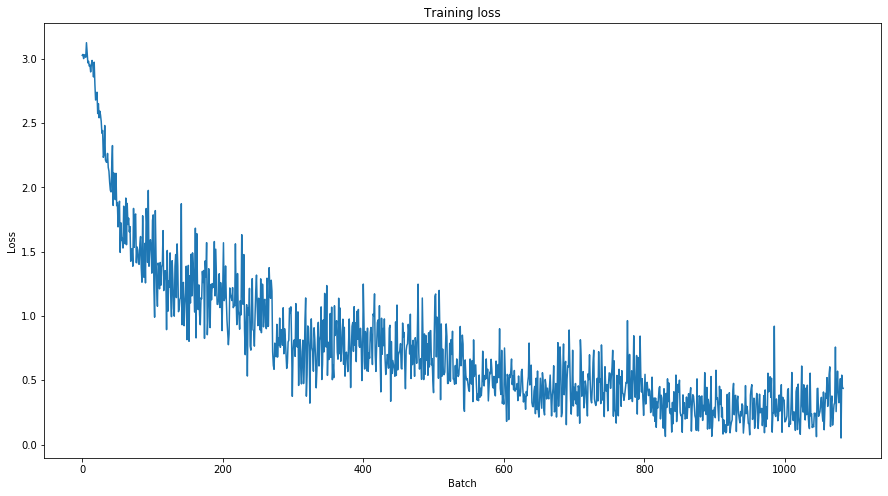

In [35]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [0]:
# predicitonon hold out set
df = df_test

# Create sentence and label lists
sentences = df.text.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent)[:511] for sent in sentences]

In [37]:
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (690 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (626 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (682 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1480 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (2684 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [41]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.7179299294500862

In [42]:
print(flat_predictions)

[ 3 14 11 ...  8  4  8]


In [43]:
print(flat_true_labels)

[3, 14, 11, 9, 9, 2, 12, 3, 9, 17, 17, 9, 9, 4, 4, 14, 4, 2, 15, 11, 11, 16, 1, 5, 13, 6, 5, 0, 6, 13, 1, 0, 2, 10, 16, 6, 5, 18, 9, 12, 10, 18, 3, 12, 2, 5, 14, 15, 13, 11, 13, 4, 5, 7, 2, 4, 10, 4, 7, 6, 5, 14, 8, 0, 17, 16, 15, 9, 12, 6, 11, 8, 12, 6, 13, 18, 1, 11, 12, 1, 8, 11, 9, 0, 1, 9, 2, 18, 12, 13, 6, 9, 16, 4, 0, 1, 8, 4, 12, 3, 17, 15, 2, 9, 11, 17, 16, 9, 13, 18, 11, 10, 9, 11, 15, 14, 17, 9, 10, 12, 11, 18, 8, 2, 10, 17, 2, 8, 10, 10, 1, 18, 9, 18, 0, 4, 11, 12, 7, 2, 11, 17, 3, 10, 14, 5, 19, 9, 3, 3, 12, 0, 15, 5, 14, 14, 14, 10, 13, 10, 14, 19, 15, 19, 8, 3, 8, 16, 6, 12, 3, 13, 18, 10, 16, 2, 5, 1, 2, 19, 14, 19, 2, 12, 17, 13, 6, 18, 8, 7, 5, 2, 11, 7, 4, 14, 8, 4, 5, 10, 12, 3, 11, 17, 1, 10, 4, 1, 19, 19, 15, 17, 2, 2, 9, 11, 15, 19, 1, 3, 5, 18, 12, 18, 7, 3, 11, 19, 6, 18, 15, 15, 15, 5, 5, 8, 14, 11, 13, 14, 15, 17, 13, 9, 4, 13, 14, 9, 4, 12, 16, 8, 5, 16, 8, 1, 2, 15, 19, 4, 8, 12, 7, 2, 18, 4, 7, 9, 0, 10, 13, 2, 10, 3, 18, 11, 0, 16, 7, 7, 15, 18, 13, 3, 15

In [0]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [45]:
results = confusion_matrix(flat_true_labels, flat_predictions) 
print ('Confusion Matrix :')
print(results) 

Confusion Matrix :
[[44  0  0  0  0  0  0  5  0  1  0  0  0  1  1 12  1  0  2  5]
 [ 2 65  7  3  2  2  2  2  0  0  0  0  1  0  2  0  0  0  0  0]
 [ 0  5 62  8  1  3  1  7  0  1  0  0  0  1  0  0  0  0  0  0]
 [ 0  2  3 62  9  0  4  2  0  0  0  0  5  1  0  0  0  0  0  0]
 [ 0  1  0 11 60  0  7  4  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  5  5  0  1 74  2  0  0  0  0  1  0  0  1  0  0  0  0  0]
 [ 0  1  0  1  3  1 78  1  0  1  0  0  0  0  0  1  0  0  1  0]
 [ 1  0  0  0  1  0  1 75  3  3  0  0  2  0  0  0  1  0  1  1]
 [ 0  1  0  0  2  0  3 16 59  0  0  0  3  3  1  0  1  0  1  0]
 [ 1  1  0  0  0  0  0  4  1 76  3  1  0  0  0  1  1  0  0  0]
 [ 2  0  0  0  0  0  1  6  0  6 71  0  1  0  0  1  0  2  0  0]
 [ 2  0  2  2  1  0  0  4  0  0  0 66  4  0  0  0  6  0  2  0]
 [ 0  2  0  5  7  1  2  2  2  0  0  0 65  1  1  0  1  0  0  0]
 [ 3  2  0  0  1  0  0  4  1  1  0  0  2 68  2  0  1  0  3  1]
 [ 1  1  1  0  3  1  0  3  1  1  0  0  1  3 68  0  0  0  3  2]
 [ 5  0  0  0  0  0  0  0  1  0  0  

In [46]:
pd.DataFrame(results) #neater

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,44,0,0,0,0,0,0,5,0,1,0,0,0,1,1,12,1,0,2,5
1,2,65,7,3,2,2,2,2,0,0,0,0,1,0,2,0,0,0,0,0
2,0,5,62,8,1,3,1,7,0,1,0,0,0,1,0,0,0,0,0,0
3,0,2,3,62,9,0,4,2,0,0,0,0,5,1,0,0,0,0,0,0
4,0,1,0,11,60,0,7,4,0,0,0,0,4,0,0,0,0,0,0,0
5,0,5,5,0,1,74,2,0,0,0,0,1,0,0,1,0,0,0,0,0
6,0,1,0,1,3,1,78,1,0,1,0,0,0,0,0,1,0,0,1,0
7,1,0,0,0,1,0,1,75,3,3,0,0,2,0,0,0,1,0,1,1
8,0,1,0,0,2,0,3,16,59,0,0,0,3,3,1,0,1,0,1,0
9,1,1,0,0,0,0,0,4,1,76,3,1,0,0,0,1,1,0,0,0


In [47]:
print ('Accuracy Score :',accuracy_score(flat_true_labels, flat_predictions) )

Accuracy Score : 0.7314487632508834


Truncation leads to a marginal drop in accuracy after the 2nd place  after decimal point.. which is ok..

In [48]:
print ('Report : ')
print (classification_report(flat_true_labels, flat_predictions) )

Report : 
              precision    recall  f1-score   support

           0       0.51      0.61      0.55        72
           1       0.74      0.74      0.74        88
           2       0.78      0.70      0.73        89
           3       0.67      0.70      0.69        88
           4       0.66      0.69      0.67        87
           5       0.90      0.83      0.87        89
           6       0.76      0.89      0.82        88
           7       0.49      0.84      0.62        89
           8       0.81      0.66      0.72        90
           9       0.82      0.85      0.84        89
          10       0.88      0.79      0.83        90
          11       0.93      0.74      0.82        89
          12       0.70      0.73      0.71        89
          13       0.84      0.76      0.80        89
          14       0.84      0.76      0.80        89
          15       0.67      0.80      0.73        90
          16       0.75      0.68      0.71        82
          17     